<a href="https://colab.research.google.com/github/carpetmat/Class-Activity_Project-1/blob/master/Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Project 1**

Here is a helpful page: https://oceanobservatories.org/ooi-m2m-interface/

Timestamp conversion code found here: https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/extras2/Synchronous_Requests_and_Basic_Plotting.ipynb

I used this method specifically: https://github.com/ooi-data-review/2018-data-workshops/blob/master/chemistry/examples/extras2/Using_the_OOI_API_with_Python.ipynb

## Import ALL the things

In [0]:
#Some of these imorts may no longer be relevant, will weed out useless improts later.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import requests
import datetime
!pip install suntime
from suntime import Sun, SunTimeException
import os
import re
import pandas as pd
import time
import json
!pip install thredds_crawler
from thredds_crawler.crawl import Crawl

!pip install timezonefinder
from timezonefinder import TimezoneFinder


     |████████████████████████████████| 38.1MB 106kB/s 


My OOI API info, and base url.

In [0]:
API_USERNAME = 'OOIAPI-4VTWFS3K3O00B9'
API_TOKEN = 'TEMP-TOKEN-C4MWINON0JLKT1'

In [0]:
SENSOR_BASE_URL = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

## Set up our reusable functions

In [0]:
# A quick function to make an API request and print the results
def get_and_print_api(url):
  r = requests.get(url, auth=(API_USERNAME, API_TOKEN))
  data = r.json()
  for d in data:
    print( d )

In [0]:
# Time Processing Routine
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

In [0]:
# Data request and download
def Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN):

  data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
  r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
  Data_url_add_to_queue = r.json()
  #Data_url_add_to_queue = datacheck['allURLs'][0]
  
  return Data_url_add_to_queue

In [0]:
#Here I attempt to count the peaks V3
def DiveIndexerV3(Depth):
  peak_range = []
  valley_range = []
  Max_Dive_Depth = max(Depth)
  Min_Dive_Depth = min(Depth)

  for d in range(0,len(Depth)):
    if (Depth[d] > (0.95 * Max_Dive_Depth)):
      peak_range.append(d)
    if (Depth[d] < (0.8 * Max_Dive_Depth)):
      valley_range.append(d)

  # plt.plot(Depth)
  # plt.plot(peak_range, Depth[peak_range], "x")
  # plt.plot(valley_range, Depth[valley_range], "o")
  # plt.plot(np.zeros_like(Depth), "--", color="gray")
  # plt.show()


  #maybe if I am brave, I will get this to put each dive's data into a seperate array
  count_ends = 0
  for p in range(0,len(peak_range)):
    if p == 0:
      # print(peak_range[p])
      count_ends += 1
    if p > 0 and p < len(peak_range)-2:
      if peak_range[p]-1 != peak_range[p-1]:
        # print(peak_range[p])
        count_ends += 1
      if peak_range[p]+1 != peak_range[p+1]:
        # print(peak_range[p])
        count_ends += 1
    if p == len(peak_range)-1:
      # print(peak_range[p])
      count_ends += 1
  
  peak_count = round(count_ends/2)
  print(peak_count)

  return peak_count

In [0]:
 def Check_and_Pull(datacheck,Profiler_Name,Season):

  #For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
  #%%time
  print('Checking data for',Profiler_Name, 'in',Season)
  #This is the part that checls to ensure the link is ready to go.
  check_complete = datacheck['allURLs'][1] + '/status.txt'
  for i in range(1000): 
      r = requests.get(check_complete)
      if r.status_code == requests.codes.ok:
          print('request completed', )
          break
      else:
          time.sleep(.5)

  #This part then finds and downloads the requested csv file.
  url = datacheck['allURLs'][0]
  c = Crawl(url, select=['.*\.csv$'], debug=False)
  urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
  #print(urls)
  data = pd.read_csv(urls[0])
  #data

  #No need to check headers for this, forutnately
  Time = data.time

  #Convert timestamp to datetime
  Time = Time.apply(ntp_seconds_to_datetime)
  #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
  # Time = pd.Series([val.time() for val in Time])

  #Find times of sunrise and sunset
  latitude  = data.lat[0]
  longitude = data.lon[0]
  Time_Sample = Time[0]

  #Hmmm I am in UTC and don't want to try converting to a different timezone atm. No thank you.
  tf = TimezoneFinder()
  # print(tf.timezone_at(lng=longitude, lat=latitude))

  SunTimeCheck = Sun(latitude, longitude)
  Sunrise = SunTimeCheck.get_sunrise_time(Time_Sample)
  Sunset = SunTimeCheck.get_sunset_time(Time_Sample)

  # SunriseCheck = SunTimeCheck.get_local_sunrise_time(Time_Sample)
  print('Sunrise at: ', Sunrise.strftime('%H:%M'), 'UTC')
  # SunsetCheck = SunTimeCheck.get_local_sunset_time(Time_Sample)
  print('Sunset at: ', Sunset.strftime('%H:%M'), 'UTC')

  #Now that we theoretically just got data, lets create a data frame we can export
  Data_Return = pd.DataFrame((),
                              columns=['Time','Depth', 'Temperature', 'Salinity', 'SpeedOfSound'])
  Data_Return.Time = Time
  #Lets check to see if we can find the correct headers when pulling data
  #For Pressure
  if ('seawater_pressure' in data):
    Data_Return.Depth = data.seawater_pressure
  else:
    Data_Return.Depth = data.pressure

  #For Temperature
  if ('seawater_temperature' in data):
    Data_Return.Temperature = data.seawater_temperature
  elif ('temp' in data):
    Data_Return.Temperature = data.temp
  else:
    Data_Return.Temperature = data.temperature
    
  #For Salinity
  if ('practical_salinity' in data):
    Data_Return.Salinity = data.practical_salinity
  else:
    Data_Return.Salinity = data.salinity

  Data_Return.SpeedOfSound = 1449.2 + 4.6*Data_Return.Temperature - 0.055*Data_Return.Temperature**2 + 0.00029*Data_Return.Temperature**3 + (1.34 - 0.01 * Data_Return.Temperature)*(Data_Return.Salinity - 35) + 0.016*Data_Return.Depth

  PeakTest = DiveIndexerV3(Data_Return.Depth)
  print('Number of dives =',PeakTest, '(May be off, still troubleshooting)')

  return Data_Return

In [0]:
# #Here I attempt to count the peaks V1
# def DiveIndexerV1(Depth):
#   Depth_Max = max(Depth)
#   DiveCount = 0
#   if Depth[0] > (0.5 * Depth_Max):
#     Diving = False
#   else:
#     Diving = True

#   for d in range(0,len(Depth)):

#     if(Depth[d] > (0.90 * Depth_Max) and not Diving):
#       Diving = True 

#     if(Depth[d] < (0.90 * Depth_Max) and Diving):
#       Diving = False
#       DiveCount += 1
#   return DiveCount

In [0]:
def Print_Graphs(Data_Table1,Data_Table2):

  plt.figure(1, figsize=[20,5])
  plt.subplot(1,2,1)
  X1 = Data_Table1.SpeedOfSound
  Y1 = Data_Table1.Depth
  plt.scatter(X1,Y1)
  plt.gca().invert_yaxis()
  plt.xlabel('Speed of Sound (m/s)')
  plt.ylabel('Depth (m)')
  plt.title('Depth vs Speed of Sound in Summer')

  #Find point of maximum speed of sound
  ssp_max = max(Data_Table1.SpeedOfSound)
  ssp_max_index = int(Data_Table1[Data_Table1['SpeedOfSound']==ssp_max].index[0])
  depth_of_sdp_max = Data_Table1.Depth[ssp_max_index]
  plt.scatter(ssp_max,depth_of_sdp_max, c="r")
  print('for Summer max ssp is:',ssp_max, 'at a depth of:',depth_of_sdp_max)

  plt.subplot(1,2,2)
  X2 = Data_Table2.SpeedOfSound
  Y2 = Data_Table2.Depth
  plt.scatter(X2,Y2)
  plt.gca().invert_yaxis()
  plt.xlabel('Speed of Sound (m/s)')
  plt.ylabel('Depth (m)')
  plt.title('Depth vs Speed of Sound in Winter')

  #Find point of maximum speed of sound
  ssp_max = max(Data_Table2.SpeedOfSound)
  ssp_max_index = int(Data_Table2[Data_Table2['SpeedOfSound']==ssp_max].index[0])
  depth_of_sdp_max = Data_Table2.Depth[ssp_max_index]
  plt.scatter(ssp_max,depth_of_sdp_max, c="r")
  print('for Winter max ssp is:',ssp_max, 'at a depth of:',depth_of_sdp_max)

  plt.figure(2, figsize=[20,5])
  plt.subplot(1,2,1)
  X3 = Data_Table1.Time
  Y3 = Data_Table1.Depth
  plt.scatter(X3,Y3)
  plt.gca().invert_yaxis()
  xformatter = mdates.DateFormatter('%H:%M')
  plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
  plt.xlabel('Time (s)')
  plt.ylabel('Depth (m)')
  plt.title('Depth vs Time in Summer')
  plt.xlim([datetime.date(Data_Table1.Time[0].year, Data_Table1.Time[0].month, Data_Table1.Time[0].day), datetime.date(Data_Table1.Time[0].year, Data_Table1.Time[0].month, Data_Table1.Time[0].day+1)])

  plt.subplot(1,2,2)
  X4 = Data_Table2.Time
  Y4 = Data_Table2.Depth
  plt.scatter(X4,Y4)
  plt.gca().invert_yaxis()
  xformatter = mdates.DateFormatter('%H:%M')
  plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
  plt.xlabel('Time (s)')
  plt.ylabel('Depth (m)')
  plt.title('Depth vs Time in Winter')
  plt.xlim([datetime.date(Data_Table2.Time[0].year, Data_Table2.Time[0].month, Data_Table2.Time[0].day), datetime.date(Data_Table2.Time[0].year, Data_Table2.Time[0].month, Data_Table2.Time[0].day+1)])

# Find Information on the sensor thingys

In [0]:
# r = requests.get(SENSOR_BASE_URL, auth=(API_USERNAME, API_TOKEN))
# print( r.status_code )
# print( r.headers )
# print( r.encoding )
# print( r.text )
# print( r.json() )

In [0]:
# sites = r.json()
# for site in sites:
#   print( site )

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Nodes for a Site
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Sensors (Instruments) for a Node
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Methods for a Sensor
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B/2A-CTDPFA107')

In [0]:
# #CE04OSPD-DP01B-01-CTDPFL105
# #List of Data Streams for a Method
# get_and_print_api(SENSOR_BASE_URL+'/CE04OSPS/SF01B/2A-CTDPFA107/streamed')

# Information from my selceted Data Ranges for each instrument

### Summer:


**1: Oregon Shelf Surface Piercing Profiler Mooring**
*   CE02SHSP-SP001-08-CTDPFJ000
*   recovered-cspp
*   ctdpf_j_cspp_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**2: Oregon Offshore Cabled Shallow Profiler Mooring**
*   CE04OSPS-SF01B-2A-CTDPFA107
*   streamed
*   ctdpf_sbe43_sample
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**3: Oregon Offshore Cabled Deep Profiler Mooring**
*   CE04OSPD-DP01B-01-CTDPFL105
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**4: Oregon Slope Base Shallow Profiler**
*   RS01SBPS-SF01A-2A-CTDPFA102
*   streamed
*   ctdpf_sbe43_sample
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**5: Oregon Slope Base Deep Profiler**
*   RS01SBPD-DP01A-01-CTDPFL104
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**6: Axial Base Shallow Profiler**
*   RS03AXPS-SF03A-2A-CTDPFA302
*   streamed
*   ctdpf_sbe43_sample
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000

**7: Axial Base Deep Profiler**
*   RS03AXPD-DP03A-01-CTDPFL304
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-07-15 00:00:00.000
*   2019-07-16 00:00:00.000


## Winter:

**1: Oregon Shelf Surface Piercing Profiler Mooring**
*   CE02SHSP-SP001-08-CTDPFJ000
*   recovered-cspp
*   ctdpf_j_cspp_instrument_recovered
*   2017-12-15 00:00:00.000
*   2017-12-16 00:00:00.000

**2: Oregon Offshore Cabled Shallow Profiler Mooring**
*   CE04OSPS-SF01B-2A-CTDPFA107
*   streamed
*   ctdpf_sbe43_sample
*   2018-12-15 00:00:00.000
*   2018-12-16 00:00:00.000

**3: Oregon Offshore Cabled Deep Profiler Mooring**
*   CE04OSPD-DP01B-01-CTDPFL105
*   recovered-wfp
*   dpc_ctd_instrument_recovered
*   2015-12-15 00:00:00.000
*   2015-12-16 00:00:00.000

**4: Oregon Slope Base Shallow Profiler**
*   RS01SBPS-SF01A-2A-CTDPFA102
*   streamed
*   ctdpf_sbe43_sample
*   2018-12-15 00:00:00.000
*   2018-12-16 00:00:00.000

**5: Oregon Slope Base Deep Profiler**
*   RS01SBPD-DP01A-01-CTDPFL104
*   recovered-wfp
*   dpc_ctd_instrument_recovered
*   2015-12-15 00:00:00.000
*   2015-12-16 00:00:00.000

**6: Axial Base Shallow Profiler**
*   RS03AXPS-SF03A-2A-CTDPFA302
*   streamed
*   ctdpf_sbe43_sample
*   2019-12-17 00:00:00.000
*   2019-12-18 00:00:00.000

**7: Axial Base Deep Profiler**
*   RS03AXPD-DP03A-01-CTDPFL304
*   recovered-inst
*   dpc_ctd_instrument_recovered
*   2019-12-15 00:00:00.000
*   2019-12-16 00:00:00.000


# Data Requests

## 1: Oregon Shelf Surface Piercing Profiler Mooring

### **Summer:**

In [0]:
# CE02SHSP-SP001-08-CTDPFJ000
# recovered_cspp
# ctdpf_j_cspp_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'CE02SHSP'
node = 'SP001'
instrument = '08-CTDPFJ000'
method = 'recovered_cspp'
stream = 'ctdpf_j_cspp_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue1S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# CE02SHSP-SP001-08-CTDPFJ000
# recovered_cspp
# ctdpf_j_cspp_instrument_recovered
# 2017-12-15 00:00:00.000
# 2017-12-16 00:00:00.000

#Instrument Information
site = 'CE02SHSP'
node = 'SP001'
instrument = '08-CTDPFJ000'
method = 'recovered_cspp'
stream = 'ctdpf_j_cspp_instrument_recovered'

params = {
    'beginDT':'2017-12-15T00:00:00.000Z',
    'endDT':'2017-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue1W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 2: Oregon Offshore Cabled Shallow Profiler Mooring

### **Summer:**

In [0]:
# CE04OSPS-SF01B-2A-CTDPFA107
# streamed
# ctdpf_sbe43_sample
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'CE04OSPS'
node = 'SF01B'
instrument = '2A-CTDPFA107'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue2S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# CE04OSPS-SF01B-2A-CTDPFA107
# streamed
# ctdpf_sbe43_sample
# 2018-12-15 00:00:00.000
# 2018-12-16 00:00:00.000

#Instrument Information
site = 'CE04OSPS'
node = 'SF01B'
instrument = '2A-CTDPFA107'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2018-12-15T00:00:00.000Z',
    'endDT':'2018-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue2W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 3: Oregon Offshore Cabled Deep Profiler Mooring

### **Summer:**

In [0]:
# CE04OSPD-DP01B-01-CTDPFL105
# recovered_inst
# dpc_ctd_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'CE04OSPD'
node = 'DP01B'
instrument = '01-CTDPFL105'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
   'format':'application/csv',
}

Data_url_add_to_queue3S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# CE04OSPD-DP01B-01-CTDPFL105
# recovered_wfp
# dpc_ctd_instrument_recovered
# 2015-12-15 00:00:00.000
# 2015-12-16 00:00:00.000

#Instrument Information
site = 'CE04OSPD'
node = 'DP01B'
instrument = '01-CTDPFL105'
method = 'recovered_wfp'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2015-12-15T00:00:00.000Z',
    'endDT':'2015-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue3W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 4: Oregon Slope Base Shallow Profiler

### **Summer:**

In [0]:
# RS01SBPS-SF01A-2A-CTDPFA102
# streamed
# ctdpf_sbe43_sample
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS01SBPS'
node = 'SF01A'
instrument = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue4S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS01SBPS-SF01A-2A-CTDPFA102
# streamed
# ctdpf_sbe43_sample
# 2018-12-15 00:00:00.000
# 2018-12-16 00:00:00.000

#Instrument Information
site = 'RS01SBPS'
node = 'SF01A'
instrument = '2A-CTDPFA102'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2018-12-15T00:00:00.000Z',
    'endDT':'2018-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue4W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 5: Oregon Slope Base Deep Profiler

### **Summer:**

In [0]:
# RS01SBPD-DP01A-01-CTDPFL104
# recovered_inst
# dpc_ctd_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS01SBPD'
node = 'DP01A'
instrument = '01-CTDPFL104'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue5S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS01SBPD-DP01A-01-CTDPFL104
# recovered_wfp
# dpc_ctd_instrument_recovered
# 2015-12-15 00:00:00.000
# 2015-12-16 00:00:00.000

#Instrument Information
site = 'RS01SBPD'
node = 'DP01A'
instrument = '01-CTDPFL104'
method = 'recovered_wfp'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2015-12-17T00:00:00.000Z',
    'endDT':'2015-12-18T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue5W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 6: Axial Base Shallow Profiler

### **Summer:**

In [0]:
# RS03AXPS-SF03A-2A-CTDPFA302
# streamed
# ctdpf_sbe43_sample
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS03AXPS'
node = 'SF03A'
instrument = '2A-CTDPFA302'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue6S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS03AXPS-SF03A-2A-CTDPFA302
# streamed
# ctdpf_sbe43_sample
# 2019-12-15 00:00:00.000
# 2019-12-16 00:00:00.000

#Instrument Information
site = 'RS03AXPS'
node = 'SF03A'
instrument = '2A-CTDPFA302'
method = 'streamed'
stream = 'ctdpf_sbe43_sample'

params = {
    'beginDT':'2019-12-15T00:00:00.000Z',
    'endDT':'2019-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue6W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

## 7: Axial Base Deep Profiler


### **Summer:**

In [0]:
# RS03AXPD-DP03A-01-CTDPFL304
# recovered-inst
# dpc_ctd_instrument_recovered
# 2019-07-15 00:00:00.000
# 2019-07-16 00:00:00.000

#Instrument Information
site = 'RS03AXPD'
node = 'DP03A'
instrument = '01-CTDPFL304'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-07-15T00:00:00.000Z',
    'endDT':'2019-07-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue7S = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

### **Winter:**

In [0]:
# RS03AXPD-DP03A-01-CTDPFL304
# recovered_inst
# dpc_ctd_instrument_recovered
# 2019-12-15 00:00:00.000
# 2019-12-16 00:00:00.000

#Instrument Information
site = 'RS03AXPD'
node = 'DP03A'
instrument = '01-CTDPFL304'
method = 'recovered_inst'
stream = 'dpc_ctd_instrument_recovered'

params = {
    'beginDT':'2019-12-15T00:00:00.000Z',
    'endDT':'2019-12-16T00:00:00.000Z',
    'format':'application/csv',
}

Data_url_add_to_queue7W = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

# Data Table Construction

In [0]:
#PRINT DAH DATAH
Profiler_Name = 'Oregon Shelf Surface Piercing Profiler Mooring'
Season = 'Summer'
Table1S = Check_and_Pull(Data_url_add_to_queue1S,Profiler_Name,Season)
Season = 'Winter'
Table1W = Check_and_Pull(Data_url_add_to_queue1W,Profiler_Name,Season)

Profiler_Name = 'Oregon Offshore Cabled Shallow Profiler Mooring'
Season = 'Summer'
Table2S = Check_and_Pull(Data_url_add_to_queue2S,Profiler_Name,Season)
Season = 'Winter'
Table2W = Check_and_Pull(Data_url_add_to_queue2W,Profiler_Name,Season)

Profiler_Name = 'Oregon Offshore Cabled Deep Profiler Mooring'
Season = 'Summer'
Table3S = Check_and_Pull(Data_url_add_to_queue3S,Profiler_Name,Season)
Season = 'Winter'
Table3W = Check_and_Pull(Data_url_add_to_queue3W,Profiler_Name,Season)

Profiler_Name = 'Oregon Slope Base Shallow Profiler'
Season = 'Summer'
Table4S = Check_and_Pull(Data_url_add_to_queue4S,Profiler_Name,Season)
Season = 'Winter'
Table4W = Check_and_Pull(Data_url_add_to_queue4W,Profiler_Name,Season)

Profiler_Name = 'Oregon Slope Base Deep Profiler'
Season = 'Summer'
Table5S = Check_and_Pull(Data_url_add_to_queue5S,Profiler_Name,Season)
Season = 'Winter'
Table5W = Check_and_Pull(Data_url_add_to_queue5W,Profiler_Name,Season)

Profiler_Name = 'Axial Base Shallow Profiler'
Season = 'Summer'
Table6S = Check_and_Pull(Data_url_add_to_queue6S,Profiler_Name,Season)
Season = 'Winter'
Table6W = Check_and_Pull(Data_url_add_to_queue6W,Profiler_Name,Season)

Profiler_Name = 'Axial Base Deep Profiler'
Season = 'Summer'
Table7S = Check_and_Pull(Data_url_add_to_queue7S,Profiler_Name,Season)
Season = 'Winter'
Table7W = Check_and_Pull(Data_url_add_to_queue7W,Profiler_Name,Season)

for Summer max ssp is: 1509.3598710503998 at a depth of: 9.885000228880001
for Winter max ssp is: 1492.5087896543018 at a depth of: 43.686000824


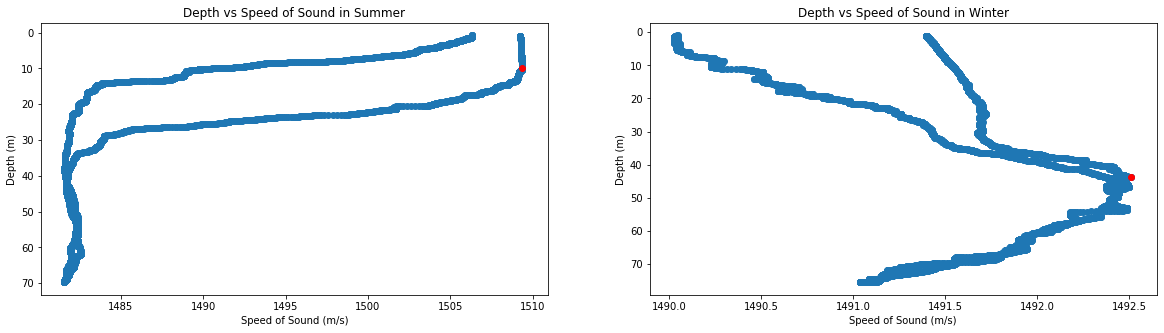

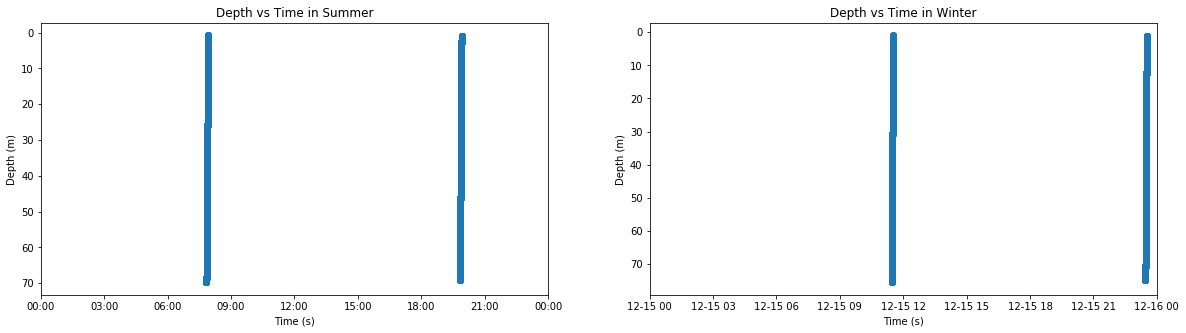

In [278]:
# Print the data:
Print_Graphs(Table1S,Table1W)

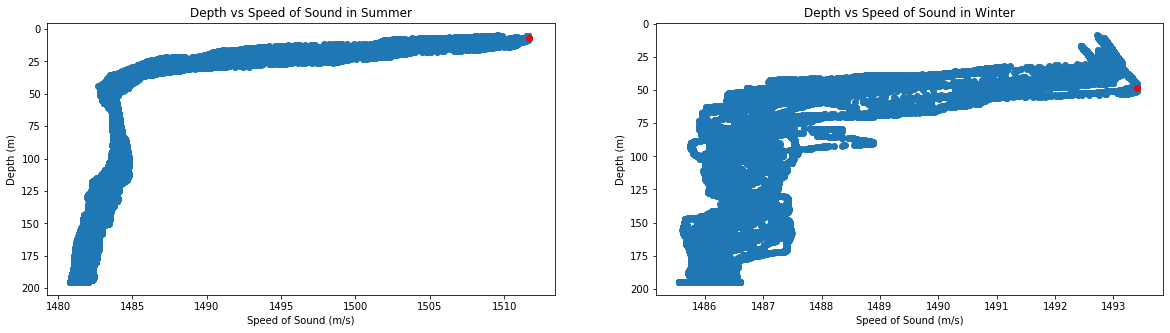

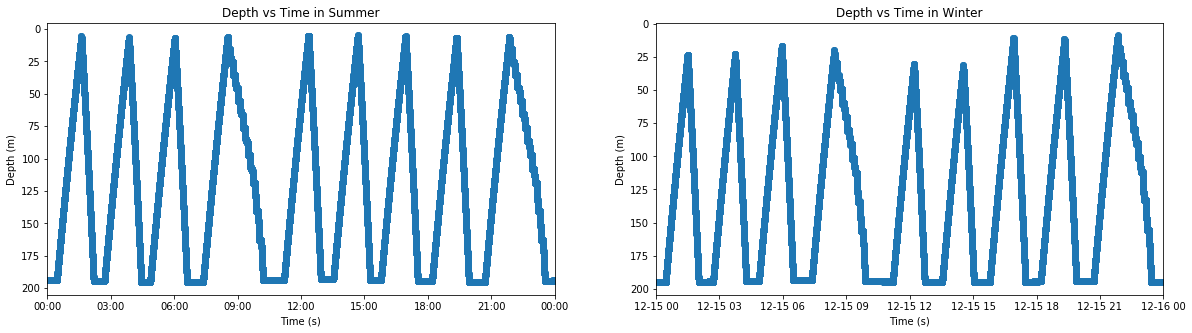

In [0]:
Print_Graphs(Table2S,Table2W)

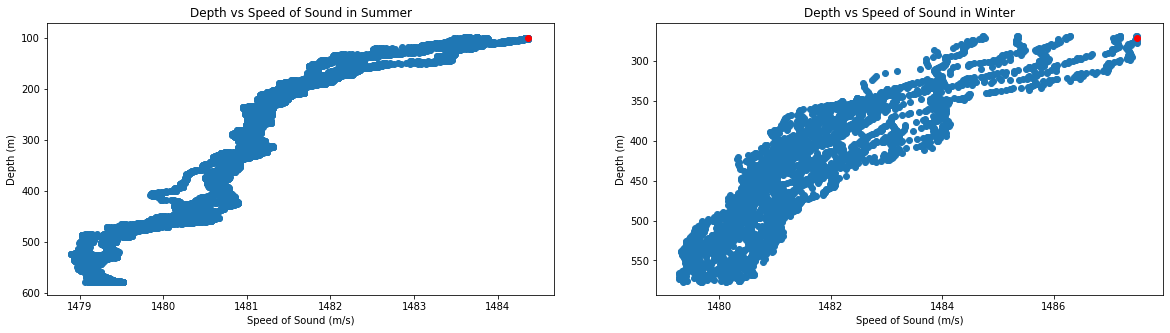

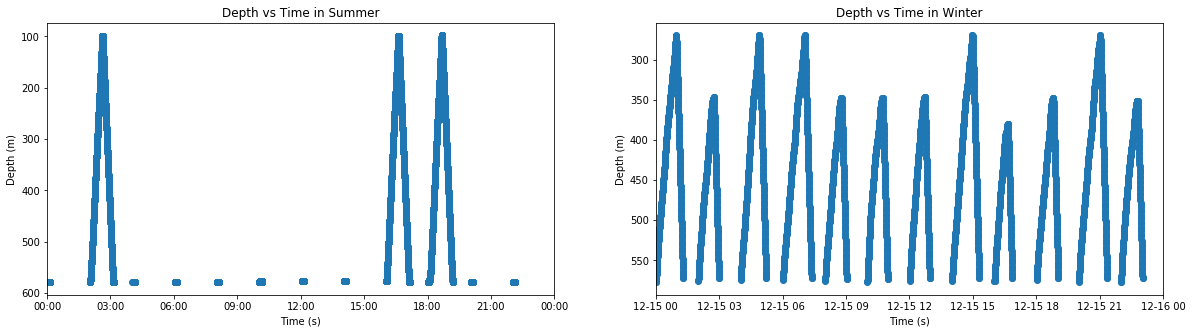

In [0]:
Print_Graphs(Table3S,Table3W)

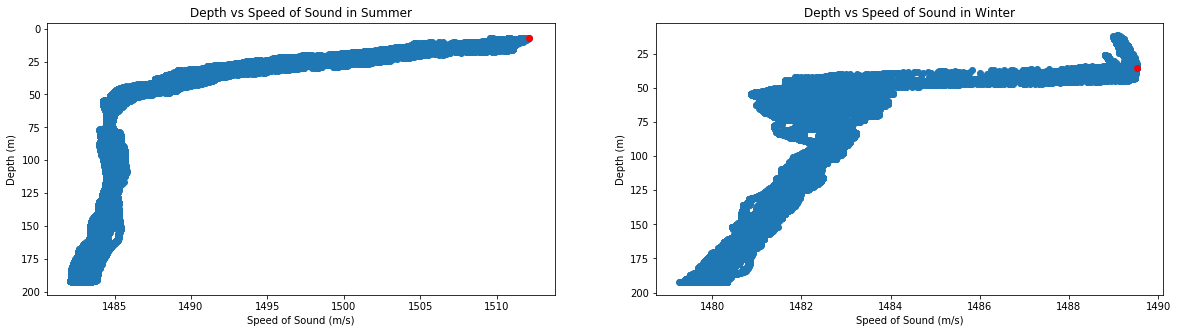

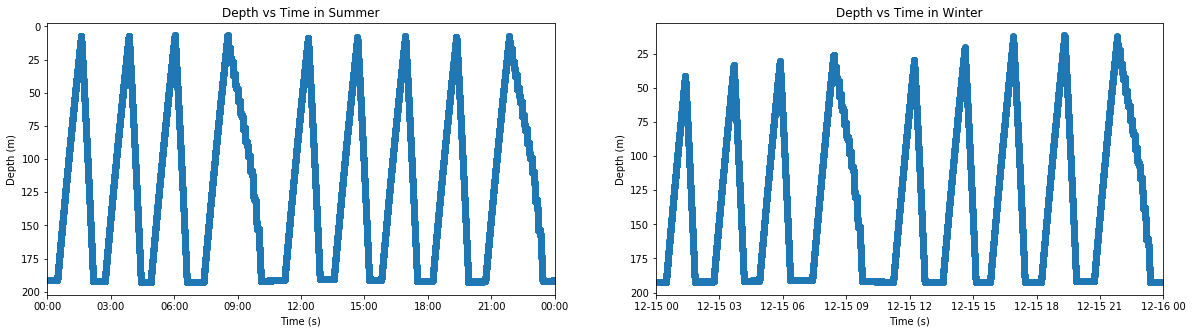

In [0]:
Print_Graphs(Table4S,Table4W)

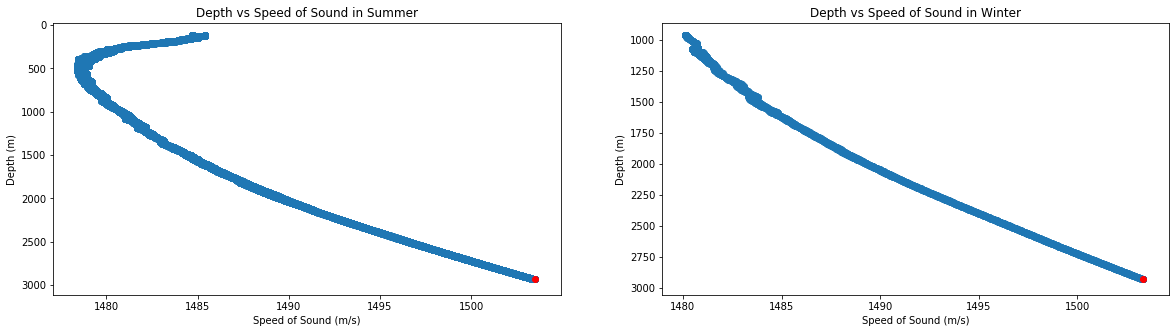

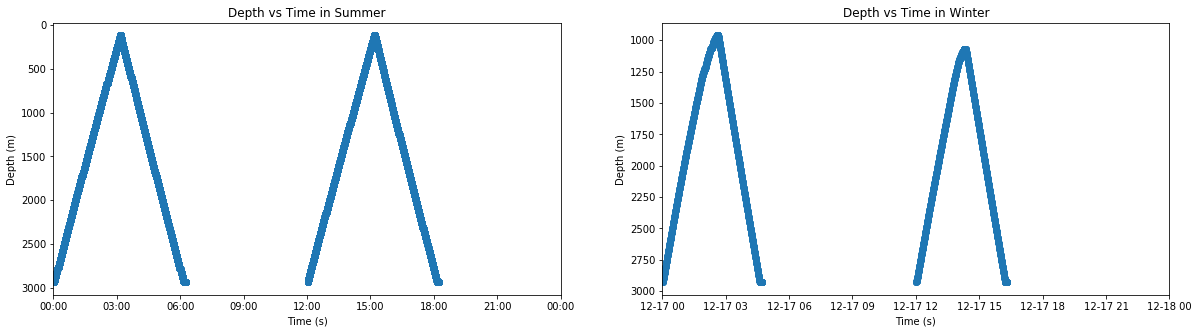

In [0]:
Print_Graphs(Table5S,Table5W)

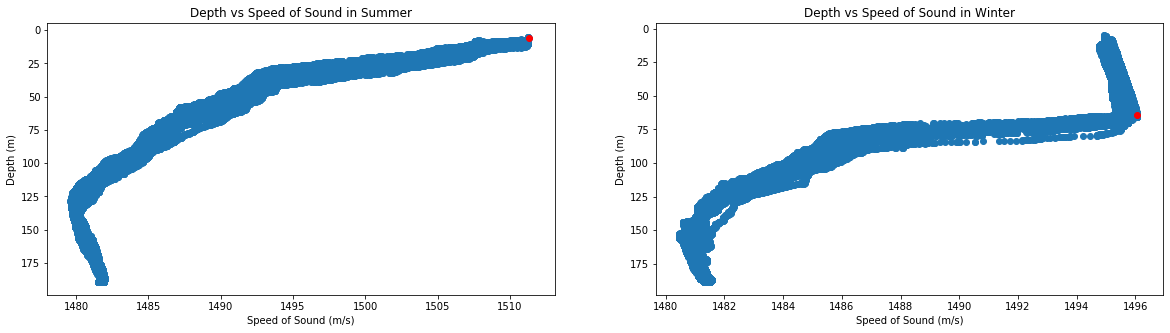

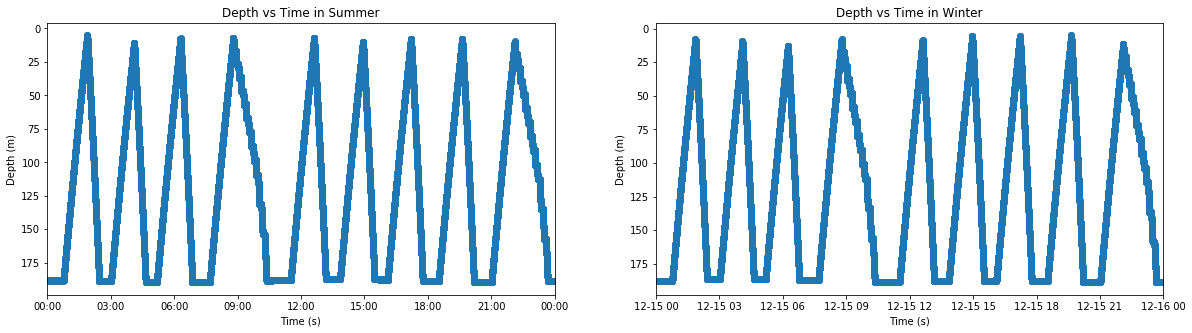

In [0]:
Print_Graphs(Table6S,Table6W)

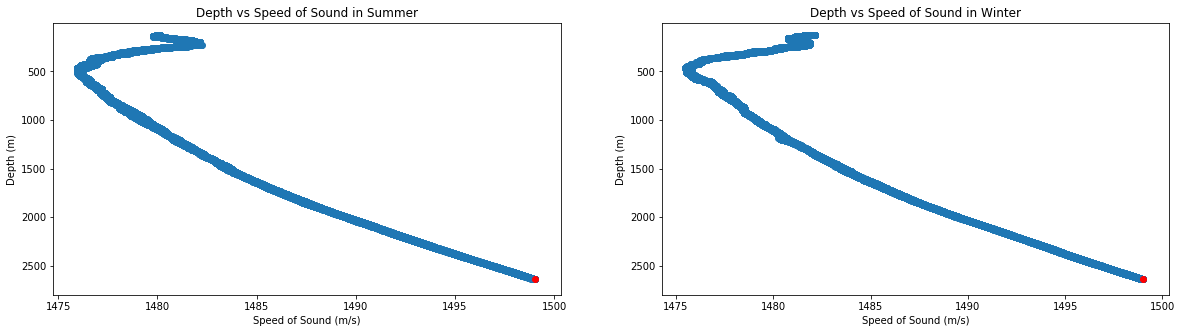

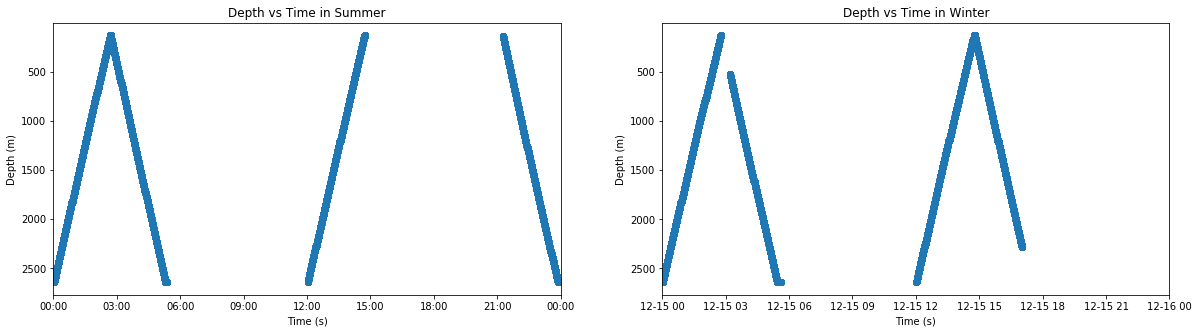

In [0]:
Print_Graphs(Table7S,Table7W)

#The end

# Backup functions for when code fails and I ugly cry

In [0]:
# # Data request and download
# def Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN):

#   data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
#   r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
#   datacheck = r.json()

#   #For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
#   #%%time
  
#   #This is the part that checls to ensure the link is ready to go.
#   check_complete = datacheck['allURLs'][1] + '/status.txt'
#   for i in range(1000): 
#       r = requests.get(check_complete)
#       if r.status_code == requests.codes.ok:
#           print('request completed')
#           break
#       else:
#           time.sleep(.5)

#   #This part then finds and downloads the requested csv file.
#   url = datacheck['allURLs'][0]
#   c = Crawl(url, select=['.*\.csv$'], debug=False)
#   urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
#   #print(urls)
#   data = pd.read_csv(urls[0])
#   #data

#   #No need to check headers for this, forutnately
#   Time = data.time

#   #Convert timestamp to datetime
#   Time = Time.apply(ntp_seconds_to_datetime)
#   #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
#   Time = pd.Series([val.time() for val in Time])

#   #Now that we theoretically just got data, lets create a data frame we can export
#   Data_Return = pd.DataFrame((),
#                               columns=['Time','Depth', 'Temperature', 'Salinity', 'SpeedOfSound'])
#   Data_Return.Time = Time
#   #Lets check to see if we can find the correct headers when pulling data
#   #For Pressure
#   if ('seawater_pressure' in data):
#     Data_Return.Depth = data.seawater_pressure
#   else:
#     Data_Return.Depth = data.pressure

#   #For Temperature
#   if ('seawater_temperature' in data):
#     Data_Return.Temperature = data.seawater_temperature
#   elif ('temp' in data):
#     Data_Return.Temperature = data.temp
#   else:
#     Data_Return.Temperature = data.temperature
    
#   #For Salinity
#   if ('practical_salinity' in data):
#     Data_Return.Salinity = data.practical_salinity
#   else:
#     Data_Return.Salinity = data.salinity

#   Data_Return.SpeedOfSound = 1449.2 + 4.6*Temperature - 0.055*Temperature**2 + 0.00029*Temperature**3 + (1.34 - 0.01 * Temperature)*(Salinity - 35) + 0.016*Depth

#   return Data_Return

In [0]:
# # CE02SHSP-SP001-08-CTDPFJ000
# # recovered_cspp
# # ctdpf_j_cspp_instrument_recovered
# # 2019-07-15 00:00:00.000
# # 2019-07-16 00:00:00.000

# #Instrument Information
# site = 'CE02SHSP'
# node = 'SP001'
# instrument = '08-CTDPFJ000'
# method = 'recovered_cspp'
# stream = 'ctdpf_j_cspp_instrument_recovered'

# params = {
#     'beginDT':'2019-07-15T00:00:00.000Z',
#     'endDT':'2019-07-16T00:00:00.000Z',
#     'format':'application/csv',
# }


#Requested_Data = Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)
#Requested_Data

##Working Example

In [0]:
#The comments below are information I have manually aquired, as automanting it seems like a whole new level of tricky.
#CE04OSPS-SF01B-2A-CTDPFA107
#streamed
#ctdpf_sbe43_sample
#2017-07-15 00:00:00.000
#2017-07-16 00:00:00.000

# # Instrument Information
# site='CE02SHSP'
# node = 'SP001'
# instrument = '08-CTDPFJ000'
# method='recovered_cspp'
# stream='ctdpf_j_cspp_instrument_recovered'
# params = {
#   'beginDT':'2017-01-04T08:02:59.950Z',
#   'endDT':'2017-01-05T08:03:00.060Z',
#   'format':'application/csv',
# }

#This builds the request link
data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# #This adds some additional information for the request.
# params = {
#     'beginDT':'2019-07-15T00:00:00.000Z',
#     'endDT':'2019-07-16T00:00:00.000Z',
#     'format':'application/csv',
# }

In [0]:
#This cell will take a minute or 2 to finish executing, as it waits to make sure the link is active before proceeding.
#The link will be generated right away, but won't work till the OOI side is ready.

# r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
# datacheck = r.json()
# print( len(datacheck) )
# datacheck
#print( datacheck['allURLs'][0])
#print( datacheck['allURLs'][1])

#For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
#%%time

# #This is the part that checls to ensure the link is ready to go.
# check_complete = datacheck['allURLs'][1] + '/status.txt'
# for i in range(1000): 
#     r = requests.get(check_complete)
#     if r.status_code == requests.codes.ok:
#         print('request completed')
#         break
#     else:
#         time.sleep(.5)

# #This part then finds and downloads the requested csv file.
# url = datacheck['allURLs'][0]
# c = Crawl(url, select=['.*\.csv$'], debug=False)
# urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
# #print(urls)
# data = pd.read_csv(urls[0])
# #data

In [0]:
# #Lets check to see if we can find the correct headers when pulling data

# #No need to check headers for this, forutnately
# Time = data.time

# #Convert timestamp to datetime
# Time = Time.apply(ntp_seconds_to_datetime)
# #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
# Time = pd.Series([val.time() for val in Time])

# #Now that we theoretically just got data, lets create a data frame we can export
# Data_Return = pd.DataFrame((),
#                             columns=['Time','Pressure', 'Temperature', 'Salinity', 'SpeedOfSound'])
# Data_Return.Time = Time
# #Lets check to see if we can find the correct headers when pulling data
# #For Pressure
# if ('seawater_pressure' in data):
#   Data_Return.Pressure = data.seawater_pressure
# else:
#   Data_Return.Pressure = data.pressure

# #For Temperature
# if ('seawater_temperature' in data):
#   Data_Return.Temperature = data.seawater_temperature
# elif ('temp' in data):
#   Data_Return.Temperature = data.temp
# else:
#   Data_Return.Temperature = data.temperature
  
# #For Salinity
# if ('practical_salinity' in data):
#   Data_Return.Salinity = data.practical_salinity
# else:
#   Data_Return.Salinity = data.salinity

# Data_Return.SpeedOfSound = 1449.2 + 4.6*Temperature - 0.055*Temperature**2 + 0.00029*Temperature**3 + (1.34 - 0.01 * Temperature)*(Salinity - 35) + 0.016*Depth
# #print(SpeedOfSound)

# # X1 = SpeedOfSound
# # Y1 = Depth
# # plt.scatter(X1,Y1)
# # plt.gca().invert_yaxis()

In [0]:
# X2 = Time
# Y2 = Depth
# plt.plot(X2,Y2)

In [0]:
#This looks helpful for my next task:
#timedatatest.rename(columns={'ctdpf_ckl_seawater_pressure': 'pressure',
#                        'ctdpf_ckl_seawater_temperature': 'temperature'}, inplace=True)

In [0]:
# fig = plt.figure()
# X1 = Table1W.SpeedOfSound
# Y1 = Table1W.Depth
# plt.scatter(X1,Y1)
# plt.gca().invert_yaxis()
# plt.xlabel('Speed of Sound (m/s)')
# plt.ylabel('Depth (m)')
# plt.title('Depth vs Speed of Sound')

# #Find point of maximum speed of sound
# ssd_max = max(Table1W.SpeedOfSound)
# ssd_max_index = int(Table1W[Table1W['SpeedOfSound']==ssd_max].index[0])
# depth_of_sdd_max = Table1W.Depth[ssd_max_index]
# plt.scatter(ssd_max,depth_of_sdd_max, c="r")

# fig = plt.figure()
# X2 = Table1W.Time
# Y2 = Table1W.Depth
# plt.scatter(X2,Y2)
# plt.gca().invert_yaxis()
# xformatter = mdates.DateFormatter('%H:%M')
# plt.gcf().axes[0].xaxis.set_major_formatter(xformatter)
# plt.xlabel('Time (s)')
# plt.ylabel('Depth (m)')
# plt.title('Depth vs Time')
# #2019-07-15T00:00:00.000Z
# plt.xlim([datetime.date(Table1W.Time[0].year, Table1W.Time[0].month, Table1W.Time[0].day), datetime.date(Table1W.Time[0].year, Table1W.Time[0].month, Table1W.Time[0].day+1)])

## Lets try a request function

In [0]:
# # Data request and download
# def Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN):

#   data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))
#   r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
#   datacheck = r.json()

#   #For some reason uncommenting this next line breaks the code. Though it works fine when it is within it's own cell.
#   #%%time

#   #This is the part that checls to ensure the link is ready to go.
#   check_complete = datacheck['allURLs'][1] + '/status.txt'
#   for i in range(1000): 
#       r = requests.get(check_complete)
#       if r.status_code == requests.codes.ok:
#           print('request completed')
#           break
#       else:
#           time.sleep(.5)

#   #This part then finds and downloads the requested csv file.
#   url = datacheck['allURLs'][0]
#   c = Crawl(url, select=['.*\.csv$'], debug=False)
#   urls = [s.get("url") for d in c.datasets for s in d.services if s.get("service").lower()== "httpserver"]
#   #print(urls)
#   data = pd.read_csv(urls[0])
#   #data

#   #No need to check headers for this, forutnately
#   Time = data.time

#   #Convert timestamp to datetime
#   Time = Time.apply(ntp_seconds_to_datetime)
#   #Now cut off the "date" part of the datetime (I'm sure there was a single line way to do this, Oh well).
#   Time = pd.Series([val.time() for val in Time])

#   #Now that we theoretically just got data, lets create a data frame we can export
#   Data_Return = pd.DataFrame((),
#                               columns=['Time','Pressure', 'Temperature', 'Salinity', 'SpeedOfSound'])
#   Data_Return.Time = Time
#   #Lets check to see if we can find the correct headers when pulling data
#   #For Pressure
#   if ('seawater_pressure' in data):
#     Data_Return.Pressure = data.seawater_pressure
#   else:
#     Data_Return.Pressure = data.pressure

#   #For Temperature
#   if ('seawater_temperature' in data):
#     Data_Return.Temperature = data.seawater_temperature
#   elif ('temp' in data):
#     Data_Return.Temperature = data.temp
#   else:
#     Data_Return.Temperature = data.temperature
    
#   #For Salinity
#   if ('practical_salinity' in data):
#     Data_Return.Salinity = data.practical_salinity
#   else:
#     Data_Return.Salinity = data.salinity

#   Data_Return.SpeedOfSound = 1449.2 + 4.6*Temperature - 0.055*Temperature**2 + 0.00029*Temperature**3 + (1.34 - 0.01 * Temperature)*(Salinity - 35) + 0.016*Depth

#   return Data_Return

In [0]:
# #Instrument Information to build request link
# site = 'CE04OSPS'
# node = 'SF01B'
# instrument = '2A-CTDPFA107'
# method = 'streamed'
# stream = 'ctdpf_sbe43_sample'

# #This builds the request link
# data_request_url ='/'.join((SENSOR_BASE_URL,site,node,instrument,method,stream))

# #This adds some additional information for the request.
# params = {
#     'beginDT':'2019-07-15T00:00:00.000Z',
#     'endDT':'2019-07-16T00:00:00.000Z',
#     'format':'application/csv',
# }
# #Requested_Data= pd.DataFrame()
# Requested_Data= Grab_CTD_Data(SENSOR_BASE_URL,site,node,instrument,method,stream,params,API_USERNAME,API_TOKEN)

In [0]:
#Here I attempt to find peaks
# def DiveIndexer(Depth):
#   peaks, _ = find_peaks(Depth, height = 0.9*Depth_Max)

#   plt.plot(Depth)
#   plt.plot(peaks, Depth[peaks], "x")
#   plt.plot(np.zeros_like(Depth), "--", color="gray")
#   plt.show()

#   return peaks

# PeakTest = DiveIndexer(Table3W.Depth)

In [0]:
#I use this to view the entire data frame

# pd.set_option('display.max_rows', 7)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', -1)

In [0]:
#Here I attempt to find peaks
# def DiveIndexer2(Depth):
#   Depth = np.array(Depth)
#   # Find peaks(max).
#   peak_indexes = signal.argrelextrema(Depth, np.greater, order=500, mode='wrap')
#   peak_indexes = peak_indexes[0]
  
#   # Find valleys(min).
#   valley_indexes = signal.argrelextrema(Depth, np.less, order=500, mode='wrap')
#   valley_indexes = valley_indexes[0]
  
#   # Plot main graph.
#   (fig, ax) = plt.subplots()
#   ax.plot(Depth)
  
#   # Plot peaks.
#   peak_x = peak_indexes
#   peak_y = Depth[peak_indexes]
#   ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='green', label="Peaks")
  
#   # Plot valleys.
#   valley_x = valley_indexes
#   valley_y = Depth[valley_indexes]
#   ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='red', label="Valleys")
#   return peak_indexes, valley_indexes

# PeakTest = DiveIndexer2(Table3W.Depth)